In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
IMG_SHAPE = (350,350)
IMG_SHAPE_GN = (350,350,3)

In [ ]:
# Process image (input) for the model
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SHAPE)
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

# Read image
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# Visualize samples
def visualize_samples(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)

    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    filepaths = "../input/dentalpanoramic/dental-panoramic/" + filepaths
#     print(filepaths[0])
    images = filepaths.apply(get_image).reset_index(drop=True)
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(labels[sample_index])
            ax[i,j].set_axis_off()
    plt.show()


# Make classifications & visualize results
def visualize_classifications(model, datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)

    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    filepaths = "../input/dentalpanoramic/dental-panoramic/" + filepaths
#     print(filepaths[0])
    images = filepaths.apply(get_image).reset_index(drop=True)
    processed_images = np.vstack(images.apply(process).to_numpy()[:])

    y_pred = classes[np.argmax(model.predict(processed_images, verbose=0), axis=1)]
    y_pred = pd.Series(y_pred).replace({"penyakit-non-periodontal":"NOT Periodontal", "penyakit-periodontal":"Periodontal"}).to_numpy()
    y_true = labels
    y_true = pd.Series(labels).replace({"penyakit-non-periodontal":"NOT Periodontal", "penyakit-periodontal":"Periodontal"}).to_numpy()

    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)

    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            is_correct_answer = "correct" if y_pred[sample_index] == y_true[sample_index] else "wrong"
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(f"({y_pred[sample_index]}) [{is_correct_answer}]")
            ax[i,j].set_axis_off()
    plt.show()

def sched(epoch, lr):
    return lr * tf.math.exp(-0.1)

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
  )


validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming IMG_SHAPE is defined, e.g., IMG_SHAPE = (150, 150)
IMG_SHAPE = (150, 150)

[ ]

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Assuming 20% of the data is used for validation
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Correct directory path
dataset_path = '/content/drive/My Drive/dental-panoramic'

# Loading training data
train_gen_flow = train_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=IMG_SHAPE,
    batch_size=64,
    class_mode="binary",
    subset='training'
)

# Loading validation data
valid_gen_flow = validation_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=IMG_SHAPE,
    batch_size=64,
    class_mode="binary",
    subset='validation'
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [ ]:
pretrainedModel = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE_GN,
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

x = tf.keras.layers.Dense(256, activation='selu')(pretrainedModel.output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='selu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='selu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 350, 350, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 175, 175, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 175, 175, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 175, 175, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
model.fit(
    train_gen_flow,
    validation_data=valid_gen_flow,
    verbose=1,
    epochs=20,
    callbacks = [tf.keras.callbacks.LearningRateScheduler(sched)],
)

Epoch 1/20
2/2 [==============================] - 33s 24s/step - loss: 1.6125 - accuracy: 0.5625 - recall: 0.4750 - val_loss: 0.9189 - val_accuracy: 0.6000 - val_recall: 1.0000 - lr: 9.0484e-04
Epoch 2/20
2/2 [==============================] - 6s 1s/step - loss: 1.1126 - accuracy: 0.5875 - recall: 0.7500 - val_loss: 1.8170 - val_accuracy: 0.5500 - val_recall: 0.1000 - lr: 8.1873e-04
Epoch 3/20
2/2 [==============================] - 7s 6s/step - loss: 0.9216 - accuracy: 0.6000 - recall: 0.3500 - val_loss: 0.6694 - val_accuracy: 0.6000 - val_recall: 0.7000 - lr: 7.4082e-04
Epoch 4/20
2/2 [==============================] - 5s 1s/step - loss: 0.6596 - accuracy: 0.7000 - recall: 0.8250 - val_loss: 1.0901 - val_accuracy: 0.6000 - val_recall: 1.0000 - lr: 6.7032e-04
Epoch 5/20
2/2 [==============================] - 8s 7s/step - loss: 0.8842 - accuracy: 0.6500 - recall: 0.9000 - val_loss: 0.7819 - val_accuracy: 0.6500 - val_recall: 0.9000 - lr: 6.0653e-04
Epoch 6/20
2/2 [======================

In [ ]:
print("Model Evaluation")
score = model.evaluate(valid_gen_flow)

Model Evaluation
1/1 [==============================] - 1s 1s/step - loss: 0.4874 - accuracy: 0.7500 - recall: 0.7000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

IMG_SHAPE = (350, 350)
IMG_SHAPE_GN = (350, 350, 3)
BATCH_SIZE = 64
EPOCHS = 20

# Correct directory path
dataset_path = '/content/drive/My Drive/dental-panoramic'

# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)

# Data augmentation for validation
validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
)

# Loading training data
train_gen_flow = train_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset='training'
)

# Loading validation data
valid_gen_flow = validation_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset='validation'
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [ ]:
def create_mobilenet_model(input_shape):
    pretrainedModel = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    pretrainedModel.trainable = False

    inputs = pretrainedModel.input
    x = tf.keras.layers.Dense(256, activation='selu')(pretrainedModel.output)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='selu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='selu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall()])

    return model

mobilenet_model = create_mobilenet_model(IMG_SHAPE_GN)
mobilenet_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 350, 350, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 175, 175, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 175, 175, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 175, 175, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='best_mobilenet_model.h5', save_best_only=True)
]

mobilenet_model.fit(
    train_gen_flow,
    validation_data=valid_gen_flow,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
2/2 [==============================] - ETA: 0s - loss: 2.8231 - accuracy: 0.5250 - recall_1: 0.2000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 26s 19s/step - loss: 2.8231 - accuracy: 0.5250 - recall_1: 0.2000 - val_loss: 0.6369 - val_accuracy: 0.5000 - val_recall_1: 0.5000
Epoch 2/20
2/2 [==============================] - 17s 5s/step - loss: 0.9291 - accuracy: 0.6125 - recall_1: 0.7500 - val_loss: 1.0986 - val_accuracy: 0.5000 - val_recall_1: 1.0000
Epoch 3/20
2/2 [==============================] - 17s 4s/step - loss: 1.0356 - accuracy: 0.5500 - recall_1: 0.8500 - val_loss: 1.1080 - val_accuracy: 0.5000 - val_recall_1: 0.0000e+00
Epoch 4/20
2/2 [==============================] - 17s 4s/step - loss: 1.2368 - accuracy: 0.5125 - recall_1: 0.1250 - val_loss: 0.5973 - val_accuracy: 0.6500 - val_recall_1: 0.4000
Epoch 5/20
2/2 [==============================] - 17s 14s/step - loss: 0.7451 - accuracy: 0.6000 - recall_1: 0.6750 - val_loss: 0.5619 - val_accuracy: 0.7000 - val_recall_1: 1.0000
Epoch 6/20
2/2 [==============================] - 18s 14s/step - loss: 0.7710 - accuracy: 0.6125 - recall

In [ ]:
print("Model Evaluation")
score = mobilenet_model.evaluate(valid_gen_flow)
print(f"Validation Loss: {score[0]}")
print(f"Validation Accuracy: {score[1]}")
print(f"Validation Recall: {score[2]}")


Model Evaluation
1/1 [==============================] - 3s 3s/step - loss: 0.5237 - accuracy: 0.7000 - recall_1: 0.6000
Validation Loss: 0.5237399339675903
Validation Accuracy: 0.699999988079071
Validation Recall: 0.6000000238418579


Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Number of training samples: 80
Number of validation samples: 20
94765736/94765736 [==============================] - 4s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 350, 350, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 356, 356, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 175, 175, 64)         9472      ['conv1_pad[0][0]']           
                                                                                 

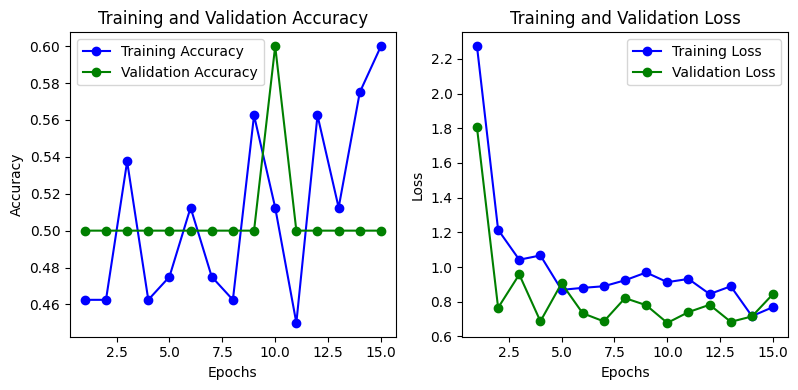

Model Evaluation
1/1 [==============================] - 2s 2s/step - loss: 0.6781 - accuracy: 0.6000 - recall_2: 0.2000
Validation Loss: 0.6780979633331299
Validation Accuracy: 0.6000000238418579
Validation Recall: 0.20000000298023224


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define image shape
IMG_SHAPE = (150, 150)
IMG_SHAPE_GN = (350, 350, 3)
BATCH_SIZE = 64
EPOCHS = 20

# Correct directory path
dataset_path = '/content/drive/My Drive/dental-panoramic'

# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)

# Data augmentation for validation
validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
)

# Loading training data
train_gen_flow = train_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset='training'
)

# Loading validation data
valid_gen_flow = validation_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset='validation'
)

# Print the number of samples
print(f"Number of training samples: {train_gen_flow.samples}")
print(f"Number of validation samples: {valid_gen_flow.samples}")

# Define the ResNet50 model
def create_resnet_model(input_shape):
    pretrainedModel = tf.keras.applications.ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    pretrainedModel.trainable = False

    inputs = pretrainedModel.input
    x = tf.keras.layers.Dense(256, activation='selu')(pretrainedModel.output)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='selu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='selu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall()])

    return model

resnet_model = create_resnet_model(IMG_SHAPE_GN)
resnet_model.summary()

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='best_resnet_model.h5', save_best_only=True)
]

# Capture the history object for ResNet model
history_resnet = resnet_model.fit(
    train_gen_flow,
    validation_data=valid_gen_flow,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Plot the training history for ResNet model
def plot_training_history(history):
    # Extract metrics from the history object
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    recall = history.history.get('recall', [])
    val_recall = history.history.get('val_recall', [])

    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation recall, if available
    if recall and val_recall:
        plt.subplot(1, 3, 3)
        plt.plot(epochs, recall, 'bo-', label='Training Recall')
        plt.plot(epochs, val_recall, 'go-', label='Validation Recall')
        plt.title('Training and Validation Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history for ResNet model
plot_training_history(history_resnet)

# Evaluate the ResNet model
print("Model Evaluation")
score = resnet_model.evaluate(valid_gen_flow)
print(f"Validation Loss: {score[0]}")
print(f"Validation Accuracy: {score[1]}")
print(f"Validation Recall: {score[2]}")


Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Number of training samples: 80
Number of validation samples: 20
Number of testing samples: 100
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                

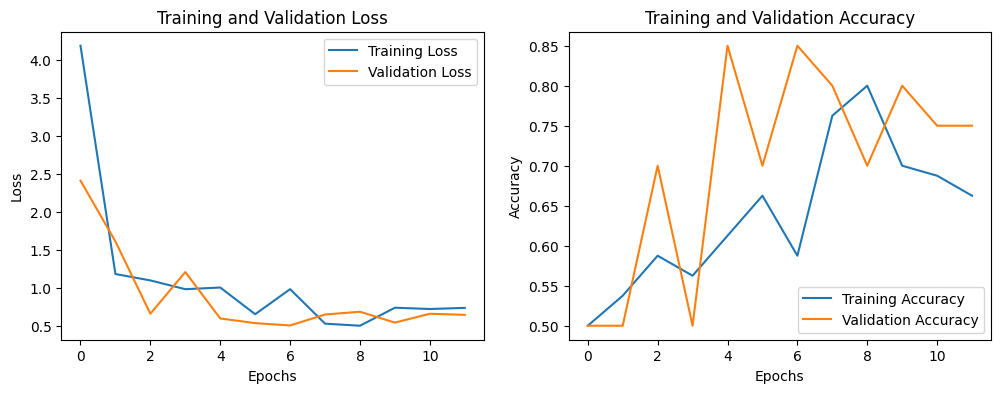

Test Set Evaluation
2/2 [==============================] - 6s 999ms/step - loss: 0.4441 - accuracy: 0.8500 - recall_1: 0.8000
Test Loss: 0.44410812854766846
Test Accuracy: 0.8500000238418579
Test Recall: 0.800000011920929
2/2 [==============================] - 2s 429ms/step


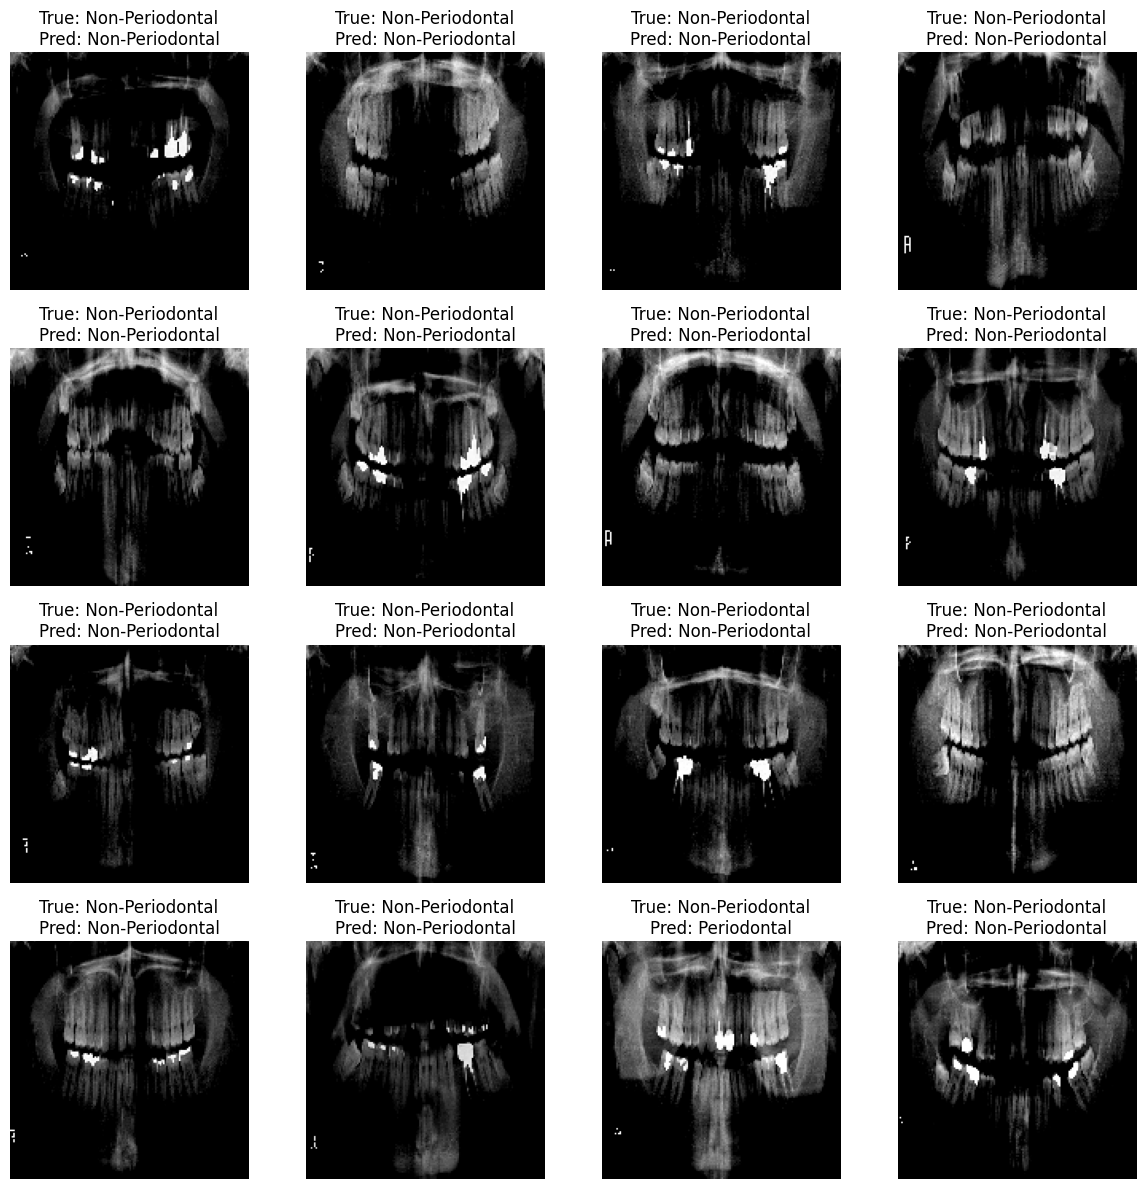

Total number of training data samples: 80
Total number of validation data samples: 20
Total number of test data samples: 100
Total augmented training images: 2560
Total augmented validation images: 1280


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Define image shape
IMG_SHAPE = (150, 150)
IMG_SHAPE_GN = (150, 150, 3)  # Adjusted to match target size
BATCH_SIZE = 64
EPOCHS = 20

# Correct directory path
dataset_path = '/content/drive/My Drive/dental-panoramic'

# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)

# Data augmentation for validation
validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
)

# Data augmentation for testing
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
)

# Loading training data
train_gen_flow = train_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset='training'
)

# Loading validation data
valid_gen_flow = validation_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset='validation'
)

# Loading test data
test_gen_flow = test_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False  # Important for testing to keep the order
)

# Print the number of samples
print(f"Number of training samples: {train_gen_flow.samples}")
print(f"Number of validation samples: {valid_gen_flow.samples}")
print(f"Number of testing samples: {test_gen_flow.samples}")

# Define the MobileNetV2 model
def create_mobilenet_model(input_shape):
    pretrainedModel = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    pretrainedModel.trainable = False

    inputs = pretrainedModel.input
    x = tf.keras.layers.Dense(256, activation='selu')(pretrainedModel.output)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='selu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='selu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall()])

    return model

mobilenet_model = create_mobilenet_model(IMG_SHAPE_GN)
mobilenet_model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_mobilenet_model.h5', save_best_only=True)
]

# Capture the history object
history = mobilenet_model.fit(
    train_gen_flow,
    validation_data=valid_gen_flow,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Calculate and print total augmented dataset size
total_train_batches = len(train_gen_flow)
total_val_batches = len(valid_gen_flow)

print(f"Total number of batches per epoch (training): {total_train_batches}")
print(f"Total number of batches per epoch (validation): {total_val_batches}")

# Calculate the total number of samples processed (assuming no early stopping)
total_train_samples = total_train_batches * BATCH_SIZE * EPOCHS
total_val_samples = total_val_batches * BATCH_SIZE * EPOCHS

print(f"Total augmented training samples: {total_train_samples}")
print(f"Total augmented validation samples: {total_val_samples}")

# Evaluate the model
print("Model Evaluation")
score = mobilenet_model.evaluate(valid_gen_flow)
print(f"Validation Loss: {score[0]}")
print(f"Validation Accuracy: {score[1]}")
print(f"Validation Recall: {score[2]}")

# Plotting the loss and accuracy over epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# Evaluate the model on the test set
print("Test Set Evaluation")
test_score = mobilenet_model.evaluate(test_gen_flow)
print(f"Test Loss: {test_score[0]}")
print(f"Test Accuracy: {test_score[1]}")
print(f"Test Recall: {test_score[2]}")

# Visualize some test images with their predictions
def visualize_predictions(model, datagen, num_images=16):
    images, labels = next(datagen)
    predictions = model.predict(images)
    predicted_labels = (predictions > 0.5).astype(int).flatten()

    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i])
        true_label = "Periodontal" if labels[i] == 1 else "Non-Periodontal"
        predicted_label = "Periodontal" if predicted_labels[i] == 1 else "Non-Periodontal"
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_predictions(mobilenet_model, test_gen_flow)

# Print the total number of data samples used
total_train_data = train_gen_flow.samples
total_val_data = valid_gen_flow.samples
total_test_data = test_gen_flow.samples

print(f"Total number of training data samples: {total_train_data}")
print(f"Total number of validation data samples: {total_val_data}")
print(f"Total number of test data samples: {total_test_data}")

# Print the total number of augmented images used
total_augmented_train_samples = total_train_batches * BATCH_SIZE * EPOCHS
total_augmented_val_samples = total_val_batches * BATCH_SIZE * EPOCHS
print(f"Total augmented training images: {total_augmented_train_samples}")
print(f"Total augmented validation images: {total_augmented_val_samples}")
